### GMRES

#### Overview

##### What is GMRES?

- GMRES is an iterative solver for a system of linear equations: $Ax=b$ 
  - $A$ is square, invertible.
- GMRES generalizes the Conjugate Gradient method to *asymmetric* matrix $A$.
  - In Conjugate Gradient, $A$ must be symmetric positive definite.
- The name is short for *generalized minimum residual* method.
- Why do we discuss that in a chapter of least square?
  - Part of its algorithm involves solving least square problem.

##### Why do we care?

- GMRES can deal with asymmetric matrix, which the conjugate gradient method fails with.
- GMRES is a good choice for the solution of large, sparse, asymmetric (square) linear system $Ax=b$. [Sauer (2017) p. 235]
- GMRES deals with ill-conditioning using orthogonality. [Sauer (2017) p. 235]

#### The method

##### Idea

- $K_j:=\mathrm{span} \{r, Ar, A^2 r, \cdots, A^j r\}$ is called *Krylov* space. ($r=b-Ax_0$) 
- The approximate solution $x_k$ at $k$-th iteration is the best approximation of the true solution $x$ in a translation of Krylov space $x_0+K_{k-1}$. 
  - Conjugate gradient method uses the similar idea. And they both belong to *Krylov methods*.
- As $k$ increases, $K_{k-1}$ expands and the approximation gets better and better.
  - In theory, GMRES is a direct method: It terminates at $n$-th iteration with the exact solution if $A$ is nonsingular. [Sauer (2017) p. 237]
  - This is called *lucky break down*. [Salgado and Wise (2023) p. 188] (See Appendix for optional details)

##### Algorithm

**Algorithm** (GMRES; Sauer (2017) p. 235)

- Given
  - $A$: $n$-by-$n$ matrix
  - $b$: vector of length $n$
- Initialize
  - $x_0$: initial guess
  - $r=b-A x_0$: initial residual 
  - $q_1=r /\|r\|_2$
- Compute
  - **for** $k=1,2, \ldots, m$
    - $y=A q_k$
    - **for** $j=1,2, \ldots, k$
      - $h_{j k}=q_j^T y $
      - $y=y-h_{j k} q$
    - $h_{k+1, k}=\|y\|_2$ (If $h_{k+1, k}=0$, skip next line and terminate at bottom.)
    - $q_{k+1}=y / h_{k+1, k}$
    - Minimize $\left\|H_k c_k- [\|r\|_2, 0, 0, \ldots, 0]^T \right\|_2$ for $c_k$
    - $x_k=Q_k c_k+x_0$

At $k$-th step, 
- $[\|r\|_2, 0, 0, \ldots, 0]$ is length $k+1$.
- $c_k$ is of length $k$.
- $H_k$ is of size $(k+1)\times k$ and given by 
 
$$
H = \left[\begin{array}{cccc}
h_{11} & h_{12} & \cdots & h_{1 k} \\
h_{21} & h_{22} & \cdots & h_{2 k} \\
& h_{32} & \cdots & h_{3 k} \\
& \ddots & \vdots \\
& & & h_{k+1, k}
\end{array}\right]
$$

  - $Q_k$ is of size $n\times k$ and given by

$$
\left[\begin{array}{c:c:c} 
& & \\
& & \\
q_1 & \cdots & q_k \\
& & \\
& &
\end{array}\right]
$$


##### Details of method

**Outline**

- At step $k$ of the method, we enlarge the Krylov space by adding $A^k r$, 
- reorthogonalize the basis (i.e., inner loop for modified Gram-Schimidt), 
- and then use least squares to find the best approximation in $x_0+K_{k-1}$.
  - This is done by finding $x_{add}$ ($Q_k c_k$ in the algorithm) and add it to $x_0$.
  - This step involves its own details.

**Details 1**


- It holds that $AQ_k = Q_{k+1} H_k$ for each $k$
  - This is a consequence of Gram-Schmidt (inner loop): with $y=A q_j$, we have orthogonal decomposition $y = \underbrace{(q_1^T y)}_{h_{1,j}} q_1 + \underbrace{(q_2^T y)}_{h_{2,j}} q_2 + \cdots + \underbrace{(q_{j+1}^T y)}_{h_{j+1,j}}q_{j+1}$ for $j=1,2,\cdots,k$.
    - This decomposition is used in the third equality below.
    - As a result, $q_{j+1} \in \mathrm{span} \{q_i\}_{i=1}^{j} \cup \{Aq_j\}$
    - We are assuming that there is no technical difficulty such as $y=A q_{j+1}\in\mathrm{span}\{q_i\}_{i=1}^{j}$.

$$
\begin{split}
AQ_k &= A\left[\begin{array}{c:c:c} 
  & & \\
  & & \\
  q_1 & \cdots & q_k \\
  & & \\
  & &
  \end{array}\right] \\
&=\left[\begin{array}{c:c:c} 
  & & \\
  & & \\
  Aq_1 & \cdots & Aq_k \\
  & & \\
  & &
  \end{array}\right]
\\
&=
\left[
	\begin{array}{c:c:c:c}
		Q_{k+1} 
		\begin{pmatrix}
  			h_{11}\\
  			h_{21}\\
  			\\
  			\\
  		\end{pmatrix} 
  		&
  		Q_{k+1} 
		\begin{pmatrix}
  			h_{12}\\
  			h_{22}\\
  			h_{32}\\
  			\\
  		\end{pmatrix}
	  	&
 		\cdots 
		&
  		Q_{k+1} 
		\begin{pmatrix}
  			h_{12}\\
  			h_{22}\\
  			h_{32}\\
  			\vdots \\
  			h_{j+1, j}
  		\end{pmatrix}
	\end{array}
  \right]
\\
& = Q_{k+1}
\left[\begin{array}{c:c:c:c}
h_{11} & h_{12} & \cdots & h_{1 k} \\
h_{21} & h_{22} & \cdots & h_{2 k} \\
& h_{32} & \cdots & h_{3 k} \\
& \ddots & \vdots \\
& & & h_{k+1, k}
\end{array}\right]
\\
&= Q_{k+1}H_k
% \left[\begin{array}{l:l:l:l} 
% & & & \\
% q_1 & \cdots & q_k & q_{k+1} \\
% & & & \\
% & & &
% \end{array}\right]\left[\begin{array}{cccc}
% h_{11} & h_{12} & \cdots & h_{1 k} \\
% h_{21} & h_{22} & \cdots & h_{2 k} \\
% & h_{32} & \cdots & h_{3 k} \\
% & \ddots & \vdots \\
% & & & h_{k+1, k}
% \end{array}\right]
\end{split}
$$


___

**Details 2**

- Notation: $\mathrm{span} Q_k:=\mathrm{span}\{q_i\}_{i=1}^{j}$ span of columns of $Q_k$.
- $\mathrm{span} Q_k = K_{k-1}$
  - the columns of $Q_k$, $q_j$'s, span the $k$-dimensional Krylov space, $K_{k-1}$.
  <!-- - $q_{j+1}$'s are products of Gram-Schmidt of $\{q_1, q_2,\cdots, A^{j-1}r\}=\{r, Ar, A^2 r,\cdots, A^{j-1}r\}$ -->
  - E.g., in the iteration for $q_{3}$, we have 
    - $\mathrm{span}\{q_1\}=\mathrm{span}\{r\}$, and
    - $\mathrm{span}\{q_1, q_2\}=\mathrm{span}\{q_1,  Aq_1\}=\mathrm{span}\{r,  Aq_1\}=\mathrm{span}\{r,  Ar\}$, 
      - where the first equality holds since $q_{j+1} \in \mathrm{span} \{q_i\}_{i=1}^{j} \cup \{Aq_j\}$ ($j=1$), and the second and third $q_1\in \mathrm{span} \{r\}$.
    - $\mathrm{span}\{q_1, q_2, q_3\}=\mathrm{span}\{q_1, q_2, Aq_2\}=\mathrm{span}\{r, Ar, A^2r\}$.
      - where the first equality holds since $q_{j+1} \in \mathrm{span} \{q_i\}_{i=1}^{j} \cup \{Aq_j\}$ ($j=2$), and the second equality is true because $q_1\in \mathrm{span} \{r\}$ and $q_2\in \mathrm{span}\{r,  Ar\}$. To be more precise, these help show $\mathrm{span}\{q_1, q_2, q_3\}\subset\mathrm{span}\{r, Ar, A^2r\}$.
      - $\mathrm{span}\{r, Ar, A^2r\}\subset\mathrm{span}\{q_1, q_2, q_3\}$ can be shown since, thanks to orthogonality of $q_j$'s, $\mathrm{dim}(\mathrm{span}\{q_1, q_2, q_3\})$ is a 3-dim subspace of $\mathrm{span}\{r, Ar, A^2r\}$, which is at most of 3-dim. 


**Details 3**

For an iteration $k$, the iterate $x_k$ minimize residual over $x_0 + K_{k-1}$, 



- Observation 1: decompose $x_k = x_0 + x_{\text {add }}$ so that $x_{\text {add }}\in K_{k-1}$, 
  - then the residual can be written $r_k = b-Ax_k = b-Ax_0 -Ax_{\text {add }} = r_0 - Ax_{\text {add }}$
  - The best approximation of $x$, in the sense of minimizing residual, among $x_k \in x_0 + K_{k-1}$, equivalently among $x_{\text {add }}\in K_{k-1}$, is obtained by a least square problem.
  - $x_{\text {add }} = Q_k c$ for some $c\in R^k$ (since $x_{\text {add }}\in K_{k-1} = \mathrm{span}Q_k$)


- Observation 2: $\| r_k \|_2 =\| Q_{k+1}^T r- H_k c \|_2 $
  -  $\| r_k \|_2 = \| b - Ax_k \|_2 = \| b - Ax_0 - A x_{\text {add }} \|_2 = \| r - A x_{\text {add }} \|_2 = \| r- AQ_k c \|_2 = \| r- Q_{k+1}H_k c \|_2 = \| Q_{k+1}^T r - H_k c \|_2 $, 
  - where we used $AQ_k = Q_{k+1}H_k$ in the 3rd equality, and 
  - in the last equality, we used $r- Q_{k+1}H_k c \in\mathrm{span} Q_{k+1}$: $r\in K_0\subset K_{k}=\mathrm{span} Q_{k+1}$ and $Q_{k+1}(H_k c) \in \mathrm{span} Q_{k+1}$ (as a linear combination columns of $Q_{k+1}$) and a 
  - lemma $\| v \|_2 = \| Q^T v \|_2$ if columns of $Q$ are mutually orthonormal and $v\in\mathrm{span} Q$ (HW problem)


- Observation 3: $Q_{k+1}^T r=\left[\begin{array}{llll}\|r\|_2 & 0 & 0 & \ldots 0\end{array}\right]^T$ (length $k+1$)
  - $q_1^T r = \| r \|_2$ since $q_1=r /\|r\|_2$ and 
  - $q_j^T r = q_j^T (\|r\|_2 q_1) = 0$ for $2\le j \le k+1$: all but the first column of $Q_{k+1}$ is orthogonal to $q_1 \parallel r$.
- Combine Observation 2 and Observation 3, then
  - $x_{\text {add }}$ minimizes $\| \left[\begin{array}{llll}\|r\|_2 & 0 & 0 & \ldots 0\end{array}\right]^T - H_k c \|_2$, in other words,
  - $x_{\text {add }}$ is the least square solution of $\tilde A \tilde x = \tilde b$, where
    - $\tilde A = H_k$
    - $\tilde b = \left[\begin{array}{llll}\|r\|_2 & 0 & 0 & \ldots 0\end{array}\right]^T$ (length $k+1$).
    - $\left[\begin{array}{cccc}h_{11} & h_{12} & \cdots & h_{1 k} \\ h_{21} & h_{22} & \cdots & h_{2 k} \\ & h_{32} & \cdots & h_{3 k} \\ & & \ddots & \vdots \\ & & & h_{k+1, k}\end{array}\right]\left[\begin{array}{c}c_1 \\ c_2 \\ \\ \vdots \\ c_k\end{array}\right]=\left[\begin{array}{c}\|r\|_2 \\ 0 \\ \\ \vdots \\ 0\end{array}\right]$

##### Some remarks

**Remark** (Sauer (2017) p. 237)

- (Lest square subproblem) 
  - The least square subproblem is the most computationally expensive part of the algorithm.
    - $k$ will be small compared to the total problem size n in most applications. 
    - The least squares step should be carried out only when an approximate solution $x_k$ is needed.
      - It is independent of other part of the algorithm, and the algorithm can proceed without computing $x_{\text{add}}=Q_k c_k$.
      - Therefore it may be done only intermittently, or at the extreme, only at the end.
- (Gram-Schmidt subroutine)
  - The Gram–Schmidt orthogonalization step carried out in the inner loop can be substituted with Householder orthogonalization at slightly increased computational complexity, if conditioning is a significant issue.
- (Exact solution)
  - In the special case $h_{k+1,k} = 0$, the least squares problem becomes square, and the approximate solution $x_k$ is exact. ()


**Remark** (Sauer (2017) p. 237)

- (Residual descent) Backward error $\|b − Ax_k \|_2$ decreases monotonically with $k$. 
  - $\|b − Ax_k \|_2 = \| r − A x_{\text{add}}\|_2$ minimized over bigger and bigger $k$-dimensional Krylov space.
- (Restart) $Q_k$ is $n \times k$ and not guaranteed to be sparse. Thus memory considerations may also limit the number k of GMRES steps.
  - In practice, one discards $Q_k$ and restart GMRES from the beginning, using the current best guess $x_k$ as the new $x_0$.
  - Restarting also helps in terms of orthogonality: $A^k r$ points to similar directions as $k$ increases.
    - Orthogonalization part of the algorithm is crucial for this reason.
- (Main application) The typical use of GMRES is for a large and sparse n × n matrix A.
  - In theory, the algorithm terminates after n steps at the correct solution x as long as A is nonsingular. 
  - In most cases, however, the goal is to run the method for k steps, where k is much smaller than n.

___

#### Computation

Computation of GMRES is a topic of computational project.

### Nonlinear least square

#### Preliminary

**Notation** 

- In the textbook, the following notations are adopted. 
- Vectors are column vectors by default.
- The gradient of a scalar function is viewed as a row vector.
  If $x\in R^n$, and $f:R^n \to R$, $\nabla f(x) = [\partial f/\partial x_i]_{i=1}^n$.
- $D$ is a Jacobian operator.
  - If $x\in R^n$, and $v:R^n \to R^n$, $D v(x)$ is a matrix whose $(i,j)$-component is given by $\partial v_i/\partial x_j$.
  - Or equivalently, $D v(x)$ is a horizontal stack of gradients of each component: $\left[\begin{array}{c}\nabla v_1 \\ \vdots \\ \nabla v_n\end{array}\right]$

**Theorem** (multidimensional product rule)

Let $u\left(x_1, \ldots, x_n\right)$ and $v\left(x_1, \ldots, x_n\right)$ be $\mathbb{R}^n$-vector-valued functions, and let $A\left(x_1, \ldots, x_n\right)$ be an $n \times n$ matrix function. The dot product $u^T v$ is a scalar function. Then, we have,


$$
\nabla\left(u^T v\right)=v^T D u+u^T D v, \quad \text{(dot product rule)}
$$

and

$$
D(A v)=A \cdot D v+\sum_{i=1}^n v_i D a_i,  \quad \text{(matrix-vector product rule)}
$$

where $a_i$ denotes the $i$ th column of $A$. 

Proof: HW problem

#### Gauss-Newton method

##### Motivating Example



**Example** (Sauer (2017) p. 212)

Write the nonlinear problem that minimizes the residual of the exponential model $y = x_1 e^{x_2 t}$ fitting the
following world automobile supply data:

| year | $t$ | cars $\left(\times 10^6\right)$ |
| :---: | :---: | :---: |
| 1950 | 0 | 53.05 |
| 1955 | 5 | 73.04 |
| 1960 | 10 | 98.31 |
| 1965 | 15 | 139.78 |
| 1970 | 20 | 193.48 |
| 1975 | 25 | 260.20 |
| 1980 | 30 | 320.39 |

$$
\left\{\begin{array}{cc}
x_1 e^{0  x_2 }&=  53.05 \\
x_1 e^{5  x_2 }&=  73.04 \\
x_1 e^{10 x_2 }&=  98.31 \\
x_1 e^{15 x_2 }&= 139.78 \\
x_1 e^{20 x_2 }&= 193.48 \\
x_1 e^{25 x_2 }&= 260.20 \\
x_1 e^{30 x_2 }&= 320.39
\end{array}\right.
$$

##### Idea

In general, for nonlinear model, we have the following form of a system of $m$ equations in $n$ unknowns
$$
\begin{aligned}
r_1\left(x_1, \ldots, x_n; t_1, y_1\right) & =0 \\
& \vdots \\
r_m\left(x_1, \ldots, x_n; t_m, y_m\right) & =0 .
\end{aligned}
$$

- $r$'s are function of model parameters, $x_i$'s, but also depend on the data $(t_i, y_i)$.
- Sum of square of residual
  - where $r=\left[r_1, \ldots, r_m\right]^T$.
  - $1 / 2$ is introduced to simplify later formulas.
 
$$
E\left(x_1, \ldots, x_n\right)=\frac{1}{2}\left(r_1^2+\cdots+r_m^2\right)=\frac{1}{2} r^T r.
$$
 
- Impose $F(x)=\nabla E(x)=\vec 0$ as a necessary condition of minimizing $E(x)$ (Fermat):
  - All derivatives appearing here, including gradient, is with respect to $x$, but not $y$.
  - $0=F(x)=\nabla E(x)=\nabla\left(\frac{1}{2} r(x)^T r(x)\right)=r(x)^T D r(x)$.
  - the last equality holds thanks to the dot product rule.
  - This gives rise to a multi-dimensional root finding problem


- Apply Multivariate Newton's Method to $F(x)$ with a simplified Jacobian matrix. 
  <!-- - $F(x)^T=\left(r^T D r\right)^T=(D r)^T r$ (column).  -->
  - $D F(x)^T=D\left((D r)^T r\right)=(D r)^T \cdot D r+\sum_{i=1}^m r_i D c_i$,
where $c_i$ is the $i$-th column of $D r$. 
  - In the last equality, we used matrix-vector product rule.
  - Ignore the last summation term. Then, the Newton's method reads:

$$
\begin{split}
x^{k+1} &= x^k - (DF(x)^T)^{-1}F(x)^T \\
&\approx x^k - ((D r)^T \cdot D r)^{-1} D r(x)^T r(x)
\end{split}
$$

<!-- - Note that $D c_i=H_{r_i}$, the matrix of second partial derivatives, or Hessian, of $r_i$ :
$$
H_{r_i}=\left[\begin{array}{ccc}
\frac{\partial^2 r_i}{\partial x_1 \partial x_1} & \cdots & \frac{\partial^2 r_i}{\partial x_1 \partial x_n} \\
\vdots & & \vdots \\
\frac{\partial^2 r_i}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 r_i}{\partial x_n \partial x_n}
\end{array}\right] .
$$ -->

**Remark** (Ignoring second order term in Jacobian)

1. Ignoring the last summation saves us the trouble of computing the individual Hessians. [Nocedal, Jorge; Wright, Stephen (1999). Numerical optimization p. 259]
2. This is more convincing when when the residuals, $r_i$, are small such as near the minimum. In practice, many least-squares problems have small residuals at the solution, and rapid local convergence of Gauss–Newton often is observed on these problems. ([Nocedal, Jorge; Wright, Stephen (1999). Numerical optimization p. 260])
3. This is appropriate when the functions are only "mildly" nonlinear, so that the entries of $Dc_i$ are relatively small in magnitude. ([Wikipedia](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm#Derivation_from_Newton's_method))

##### Algorithm

**Algorithm** (Gauss-Newton Method; Sauer (2017) p. 240)


To minimize

$$
r_1(x)^2+\cdots+r_m(x)^2 .
$$

Set $x^0=$ initial vector, 

- **for** $k=0,1,2, \ldots$.
$$
\begin{aligned}
A & =\operatorname{Dr}\left(x^k\right) \\
A^T A v^k & =-A^T r\left(x^k\right) \\
x^{k+1} & =x^k+v^k
\end{aligned}
$$

##### Some remarks

**Remark** 

- The update vector, $v^k$, is computed using Gaussian elimination, rather than inverting the matrix $A^T A$. (Gauss is involved in two ways; Least square method and Gaussian elimination.) 
<!--
- Dropping the summation part in the Jacobian is not always bad.
  - We save computations for that.
  - We have a symmetric matrix $A^T A$.
  - As long as a method suggests a good update vector $v^k$, we are still in a good situation.    
    - Jacobian serves as a "lens," through which we "see" the right direction, and lens can be a bit altered if there is a good reason.
- The partial derivatives are taken with respect to model parameters, not the input data.  -->
- Convergence is not guaranteed.
  - There may be local minima and the method can be stuck there.

#### Models with nonlinear parameters

- This is a special case the general nonlinear least square problem, hence a special case of Gauss-Newton method.
- This particular case is seen commonly enough to warrant special treatment. (Sauer (2017) p. 243)

**Problem settings**

$$
\begin{gathered}
r_1(c)=f_c\left(t_1\right)-y_1 \\
\vdots \\
r_m(c)=f_c\left(t_m\right)-y_m .
\end{gathered}
$$

That is, $y$ is decoupled from the other quantities.

**To do**

- Apply Gauss-Newton with 
  - $(D r)_{i j}=\frac{\partial r_i}{\partial c_j}=f_{c_j}\left(t_i\right)$

**Remark** 

- (Settings) Settings can be confusing since there are many variables involved.
  - Independent and dependent variables of the nonlinear least square problem.
    - Independent: $c\in R^n$
    - Model: $f(t)$
    - Dependent: $J(c)=\lVert r \rVert_2^2$ (minimization perspective) or $r\in R^m$ (equation persepctive)
    - Probelm: Find $c$ that minimizes $J$ over $c\in R^n$. ($t_i$'s and $y_i$'s are fixed.)
      - Philosophically, we accept what has happened (data) and try to find the best theory (model) that explains it.
  - Independent and dependent variables of data fitting
    - Independent: $t$
    - Dependent: $y$ 


**Example** (Population model revisited; Sauer (2017) p. 212)

Find the nonlinear least sqaure solution that minimizes the 2-norm of residual of the exponential model $y = c_1 e^{c_2 t}$ fitting the
following world automobile supply data:

| year | $t$ | cars $\left(\times 10^6\right)$ |
| :---: | :---: | :---: |
| 1950 | 0 | 53.05 |
| 1955 | 5 | 73.04 |
| 1960 | 10 | 98.31 |
| 1965 | 15 | 139.78 |
| 1970 | 20 | 193.48 |
| 1975 | 25 | 260.20 |
| 1980 | 30 | 320.39 |

$$
\left\{\begin{array}{cc}
c_1 e^{0  c_2 }&=  53.05 \\
c_1 e^{5  c_2 }&=  73.04 \\
c_1 e^{10 c_2 }&=  98.31 \\
c_1 e^{15 c_2 }&= 139.78 \\
c_1 e^{20 c_2 }&= 193.48 \\
c_1 e^{25 c_2 }&= 260.20 \\
c_1 e^{30 c_2 }&= 320.39
\end{array}\right.
$$


- Independent and dependent variables of the nonlinear least square problem.
  - Independent: $c\in R^2$
  - Model: $f(t)=c_1 e^{c_2 t}$
  - Dependent: $r=[f(t_i) - y_i]_{i=1}^7 \in R^7$ (equation persepctive)
  - Probelm: Find $c$ that minimizes $J(c)=\lVert r \rVert_2^2$ over $c\in R^2$. ($t_i$)

Since 

$$
\begin{split}
(D r)_{i 1} &= \frac{\partial r_i}{\partial c_1}=e^{c_2 t} \\
(D r)_{i 2} &= \frac{\partial r_i}{\partial c_2}=c_1 t e^{c_2 t}
\end{split}
$$

we have

$$
r = 
\begin{bmatrix}
c_1 e^{0  c_2 } -  53.05 \\
c_1 e^{5  c_2 } -  73.04 \\
c_1 e^{10 c_2 } -  98.31 \\
c_1 e^{15 c_2 } - 139.78 \\
c_1 e^{20 c_2 } - 193.48 \\
c_1 e^{25 c_2 } - 260.20 \\
c_1 e^{30 c_2 } - 320.39
\end{bmatrix},
\qquad
Dr =  
\begin{bmatrix}
e^{0  c_2 } & c_1  0   e^{0  c_2 }\\
e^{5  c_2 } & c_1  5   e^{5  c_2 }\\
e^{10 c_2 } & c_1  10  e^{10 c_2 }\\
e^{15 c_2 } & c_1  15  e^{15 c_2 }\\
e^{20 c_2 } & c_1  20  e^{20 c_2 }\\
e^{25 c_2 } & c_1  25  e^{25 c_2 }\\
e^{30 c_2 } & c_1  30  e^{30 c_2 }
\end{bmatrix}
\qquad

$$


- $r$: column vector ($m\times 1$)
- $Dr$: $m\times n$

Textbook has a typo: extra '$-$' sign in front of $Dr$.

In [49]:
import numpy as np

def nonlin_ls(data, res, Jac, c0, max_iter=20, tol=1e-8):
    """
    Return nonlinear least square solution using Gauss-Newton method.

    Input:
        data (array): 2D array 
            row 0: independent variable data of the model
            row 1: dependent variable data of the model
        res (fn): residual, a function of c (model parameter) 
            and t (independent variable of the model)
        Jac (fn): Jacobian, a function of c (model parameter) 
            and t (independent variable of the model)
        x0 (array): initial guess
        par (dict): various parameters
    Output:
        x (array): nonlinear least square solution.
    """
    t = data[0, :]
    y = data[1, :]

    c = c0

    for j in range(max_iter):
        r = res(c, t, y)
        if np.linalg.norm(r) < tol:
            break
        
        A = Jac(c, t, y)
        
        v = np.linalg.solve(A.T @ A, - A.T @ r)
        
        c = c + v
    
    return c, j

In [50]:

data =  np.array([[0 ,5 ,10,15,20,25,30],
                [53.05, 73.04, 98.31, 139.78, 193.48, 260.20, 320.39]])

# residual and Jacobian needs broadcasting: t.reshape(-1,1), y.reshape(-1,1)
res = lambda c, t, y: c[0]*np.exp(c[1]*t) - y
Jac = lambda c, t, y: np.column_stack((np.exp(c[1]*t), c[0]*t*np.exp(c[1]*t)))

c0 = np.array([50., 0.1])

c, iter = nonlin_ls(data, res, Jac, c0, max_iter=5)

with np.printoptions(precision=5, suppress=True):
    print(f" nonlinear least square solution {c} found by {iter+1} iteration")

 nonlinear least square solution [58.50774  0.05772] found by 5 iteration


**Comparison with data linearization**

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# number of data points/observations
m = 7
y = np.array([53.05, 73.04, 98.31, 139.78, 193.48, 260.20, 320.39])
# 1950 is treated as 0
t = np.arange(m)*5.

# vector of unknowns
n = 2
c_dat_lin = np.zeros(n)

# matrix of least squares
A = np.column_stack((np.ones(m), t))

# vector of observations
b = np.log(y)

# least squares solution
c_dat_lin = np.linalg.solve(A.T @ A, A.T @ b)

# invert the transoformation for c_1
c_dat_lin[0] = np.exp(c_dat_lin[0])


                 [RMSE]                 
     Nonlinear        Data linearization 
 182.4093596926231    184.96081589647792 


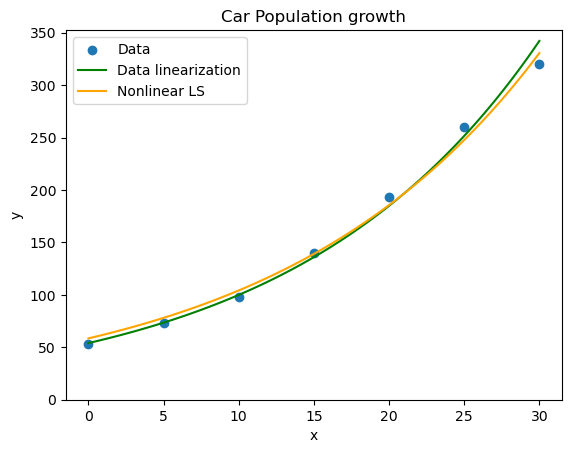

In [48]:
# AI usage: initial plotting block is doen with copilot

# Calculate the predicted values
y_pred1 = c_dat_lin[0]*np.exp(c_dat_lin[1]*t)
y_pred2 = c[0]*np.exp(c[1]*t)

# Calculate the root mean squared error
rmse_dat_lin = np.sqrt(np.mean((b - y_pred1)**2))
rmse_nonlin = np.sqrt(np.mean((b - y_pred2)**2))

print(f"{'[RMSE]':^40}")
print(f"{'Nonlinear':^20} {'Data linearization':^20}")
print(f"{rmse_nonlin:^20} {rmse_dat_lin:^20}")

# Plot the data points
plt.scatter(t, y, label='Data')

# Plot the model - data linearization
x = np.linspace(t[0], t[-1], 100)
y1 = c_dat_lin[0]*np.exp(c_dat_lin[1]*x)
plt.plot(x, y1, color='green', label='Data linearization')

y2 = c[0]*np.exp(c[1]*x)
plt.plot(x, y2, color='orange', label='Nonlinear LS')

# Set labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Car Population growth')
plt.ylim(0, np.max(y)*1.1)

# Show legend
plt.legend()

# Show the plot
plt.show()


#### Levenberg-Marquardt method

**What is it?**

- A modified version of Gauss-Newton method to deal with ill-conditioned nonlinear least sqaure problem.
  - Here, we are talking about ill-conditioned Jacobian.

**Idea**

- "Dial up diagonal entries"
  - $(A^T A + \lambda \mathrm{diag}(A^T A)) v^k  =-A^T r\left(x^k\right)$ in place of $A^T A v^k =-A^T r\left(x^k\right)$
  - $\lambda\ge 0$ is a user-tuned parameter.
  - Everything else is the same as Gauss-Newton.


**Remark**

- (Conditioning) Levenberg-Marquardt method improves the condition number and generally allows the method to converge from a broader set of initial guesses than Gauss-Newton. (Sauer (2017) p. 245)
- (History) The method originated by a suggestion in Levenberg [1944] to add $\lambda I$ to $A T A$ in Gauss–Newton to improve its conditioning. Several years later, D. Marquardt, a
statistician at DuPont, improved on Levenberg’s suggestion by replacing the identity matrix with the diagonal of A T A (Marquardt [1963]). (Sauer (2017) p. 246)
- (Parameter tuning) Although we have treated $\lambda$ as a constant for simplicity, the method is often applied adaptively with a varying $\lambda$. A common strategy is to continue to decrease $\lambda$ by a factor of 10 on each iteration step as long as the residual sum of squared errors is decreased by the step, and if the sum increases, to reject the step and increase $\lambda$ by a factor of 10. (Sauer (2017) p. 246)

### Appendix

#### Why translation, not Krylov space itself

**Remark** (Why $x_0 + K_{k-1}$, not $K_{k-1}$?)

- If we seek approximate solution $x_k$ directly from $K_{k-1}$, we have some issues in Observation 2.
  - Now, $x_k\in K_{k-1}=\mathrm{span} Q_{k}$, so $x_k=Q_k c$ for some $c\in R^k$. 

$$
\begin{split}
\| r_k \|_2 = \| b - Ax_k \|_2 = \| b- AQ_k c \|_2 = \| b- Q_{k+1}H_k c \|_2 \\
(= \| Q_{k+1}^T b - H_k c \|_2?) 
\end{split}
$$

- The last equality in question may not hold.
  - Before, we had $r$ in place $b$ and $r\in K_{k}=\mathrm{span} Q_{k+1}$ was used.
  - However, there is no guarantee that $b\in K_{k}=\mathrm{span} Q_{k+1}$.
  - Then, we need to solve more expensive problem $\mathrm{minimize }\| b- Q_{k+1}H_k c \|_2$ due to matrix multiplication.
- Also, even if this issue could be somehow resolved, this leads to more computation because Observation 3 does not hold for $b$. We had
  - $Q_{k+1}^T r=\left[\begin{array}{llll}\|r\|_2 & 0 & 0 & \ldots 0\end{array}\right]^T$ (length $k+1$), but now
  - $Q_{k+1}^T b$ must be computed.

#### Lucky break down of GMRES

Suppose $h_{k+1,k}=\lVert y \rVert_2=0$ in the GMRES algorithm for the first time at $k$-th iteration. Then, we have

1. $A K_{k-1} = K_{k-1}$.
   - $A K_{k-1} \subset K_{k-1}$ (i.e., $K_{k-1}$ is an invariant subspace of $R^m$ under $A$) 
     - First, $y = Aq_k - \mathrm{Proj}_{K_{k-1}} Aq_k$ since 
       - $\mathrm{span}\ Q_k = K_{k-1}$ and 
       - $y = Aq_k - ((Aq_k)^T q_1) q_1 - \cdots - ((Aq_k)^T q_k) q_k$. 
     - Thus, $Aq_k = \mathrm{Proj}_{K_{k-1}} Aq_k \in {K_{k-1}}$ from $y=0$. 
     - Also, $Aq_i  \in {K_{k-1}}$ for $i=1,2,\cdots, k-1$ since
       - $Aq_i \in A \mathrm{span}\ Q_i = A K_{i-1} \subset K_i$ and $K_{i} \subset {K_{k-1}}$.
     - The last two bullets of the same level implies $A K_{k-1} = A \mathrm{span}\ Q_k \subset K_{k-1}$.
   - $\{r, Ar, \cdots, A^{k-1}r\}$ is a linearly independent set because
     - $K_{k-1}=\mathrm{span} \ \{ r, Ar, \cdots, A^{k-1}r \}=\mathrm{span} \ Q_k$ is $i$-dimensional.
   - $A\{r, Ar, \cdots, A^{k-1}r\}$ is a linearly independent set because 
     - nonsingular matrix $A$ takes a linear independent sets to a linearly independent set.
   - Combining the two linear independence and $A K_{k-1} \subset K_{k-1}$ shows that $A K_{k-1} = K_{k-1}$.
2. $x \in x_0 + K_{k-1}$.
   - Observe $A(x-x_0) = Ax - Ax_0 = b - Ax_0 = r = \in K_0 \subset K_{k-1} \subset A K_{k-1}$.
   - In other words, $A(x-x_0) = \sum_{j=1}^k a_j A^j r$ for some $a_j$'s. 
   - By canceling an $A$, we have $x-x_0 = \sum_{j=1}^k a_j A^{j-1} r \in K_{k-1}$, namely, $x - x_0 \in K_{k-1}$, which is equivalent to $x \in x_0 + K_{k-1}$.
3. $x_k = x$.
   - Since $x_k$ is the (unique) least square solution over $x_0 + K_{k-1}$, it minimizes the norm of residual $\lVert r_k \rVert = \lVert b - Ax_k \rVert \ge 0$. 
   - However, $x \in x_0 + K_{k-1}$ also leads to the smallest possible norm of residual $\lVert b - Ax \rVert = \lVert \vec{0} \rVert = 0$. 
   - Therefore, $x_k = x$.


#### More information on GMRES

- Convergence
  - (Pessimistic) For every nonincreasing sequence $a_1, \cdots, a_{m−1}, a_m = 0$, one can find a matrix A such that the $\|r_n\| = a_n$ for all $n$, where $r_n$ is the $n$-th residual. In particular, it is possible to find a matrix for which the residual stays constant for $m − 1$ iterations, and only drops to zero at the last iteration. (Reference: [Wikipedia](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method#Convergence) and also the instructor heard this in a plenary talk of a very reliable conference, though details not remembered. I remember I got surprised by the fact that even solving a linear system can be inherently difficult.)
  - (Optimistic in practice) In practice, though, GMRES often performs well. This can be proven in specific situations. 
- Relationship with MINRES
  - MINRES is similar to Conjugate Gradient (CG) method, but it assumes the matrix to be only symmetric, allowing indefinite matrices, whereas CG assumes it to be symmetric positive definite.
  - The GMRES method is essentially a generalization of MINRES for arbitrary matrices. (See the technical remark for more detials if interested.)
- $H_k$ appearing in the GMRES is an upper (nonsquare) *Hessenberg matrix*. 
  - A upper Hessenberg matrix has zero entries below tridiaginal.
  - This remark is meant to familarize with terminology.
  

###### Technical remarks

**Remark** (Technical remarks on GMRES)

- (GMRES and MINRES) The GMRES method is essentially a generalization of MINRES for arbitrary matrices. Both minimize the 2-norm of the residual and do the same calculations in exact arithmetic when the matrix is symmetric. MINRES is a short-recurrence method with a constant memory requirement, whereas GMRES requires storing the whole Krylov space, so its memory requirement is roughly proportional to the number of iterations. On the other hand, GMRES tends to suffer less from loss of orthogonality. (Reference: Wikipedia, one of whose the original references is broken; treat this remark as advice, but not as truth before confirmation.)
- (No Krylov space; further study needed) The Arnoldi iteration (computations for $q_j$'s) reduces to the Lanczos iteration for symmetric matrices. The corresponding Krylov subspace method is the minimal residual method (MinRes) of Paige and Saunders. 
    - Unlike the unsymmetric case, the MinRes method is given by a three-term recurrence relation. 
    - It can be shown that there is no Krylov subspace method for general matrices, which is given by a short recurrence relation and yet minimizes the norms of the residuals, as GMRES does. (Reference: [Wikipedia](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method#Comparison_with_other_solvers))
- (Hessenberg matrix) Any matrix is unitarily similar to Henssenberg. (Reference: [Wikipedia](https://en.wikipedia.org/wiki/Hessenberg_matrix))
    - The validity of this statement is trivial by *Schur triangularization* or *Schur decomposition* ([Schur decomposition Wikipedia](https://en.wikipedia.org/wiki/Schur_decomposition)).
  - When triangularization is needed, computing a Hessenberg matrix, then moving on to a triangular matrix is more efficient. (See more detailed remark on [Wikipedia](https://en.wikipedia.org/wiki/Hessenberg_matrix#Computer_programming))
- (Convergence of GMRES) 
  - According to Greenbaum, Pták and Strakoš states that for every nonincreasing sequence $a_1, \cdots, a_{m−1}, a_m = 0$, one can find a matrix A such that the $\|r_n\| = a_n$ for all $n$, where $r_n$ is the $n$-th residual. In particular, it is possible to find a matrix for which the residual stays constant for $m − 1$ iterations, and only drops to zero at the last iteration. (Reference: [Wikipedia](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method#Convergence) and also the instructor heard this in a plenary talk of a very reliable conference, though details not remembered. I remember I got surprised by the fact that even solving a linear system can be inherently difficult.)
  - In practice, though, GMRES often performs well. This can be proven in specific situations. If the symmetric part of $A$, that is $\left(A^T+A\right) / 2$, is positive definite, then
$$
\left\|r_n\right\| \leq\left(1-\frac{\lambda_{\min }^2\left(1 / 2\left(A^T+A\right)\right)}{\lambda_{\max }\left(A^T A\right)}\right)^{n / 2}\left\|r_0\right\|,
$$
where $\lambda_{\min }(M)$ and $\lambda_{\max }(M)$ denote the smallest and largest eigenvalue of the matrix $M$, respectively. 

If $A$ is symmetric and positive definite, then we even have
$$
\left\|r_n\right\| \leq\left(\frac{\kappa_2(A)^2-1}{\kappa_2(A)^2}\right)^{n / 2}\left\|r_0\right\| .
$$
where $\kappa_2(A)$ denotes the condition number of $A$ in the Euclidean norm.

In the general case, where $A$ is not positive definite, we have
$$
\frac{\left\|r_n\right\|}{\|b\|} \leq \inf _{p \in P_n}\|p(A)\| \leq \kappa_2(V) \inf _{p \in P_n} \max _{\lambda \in \sigma(A)}|p(\lambda)|,
$$
where $P_n$ denotes the set of polynomials of degree at most $n$ with $p(0)=1, V$ is the matrix appearing in the spectral decomposition of $A$, and $\sigma(A)$ is the spectrum of $A$. Roughly speaking, this says that fast convergence occurs when the eigenvalues of $A$ are clustered away from the origin and $A$ is not too far from normality. (Reference: [Wikipedia](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method#Convergence), whose original reference is Lloyd N. Trefethen and David Bau, III, Numerical Linear Algebra, Society for Industrial and Applied Mathematics, 1997)

---
This work is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)